## 3. Hybrid Quantum-Classical Model

We now build a hybrid model combining a classical neural network with a quantum layer. The classical component uses an LSTM to extract temporal features. The quantum component is a variational quantum circuit (VQC) that acts as a nonlinear transformation layer.

We use the `PennyLane` library to construct the quantum circuit and integrate it with `PyTorch` for training.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# Download historical stock data (Apple Inc. as example)
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")


# Flatten MultiIndex columns
data.columns = data.columns.get_level_values(0)

# Use 'Close' as the main signal
data = data[['Close']].copy()
data.rename(columns={'Close': 'price'}, inplace=True)

# Forward-fill missing data (e.g., for non-trading days)
data.ffill(inplace=True)

# normalize the data to the [0, 1] range using Min-Max scaling.
scaler = MinMaxScaler()
data['normalized'] = scaler.fit_transform(data[['price']])

# To perform time series forecasting, we convert the normalized series into input/output sequences 
# using a sliding window approach.
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

# Use a window size (e.g., 20)
WINDOW_SIZE = 20
series = data['normalized'].values
X, y = create_sequences(series, WINDOW_SIZE)

# split the data into training and testing sets.
# For example, we may use the last 20% of the sequences for testing.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training sequences: (1996, 20)
Test sequences: (499, 20)


### 3.1 Quantum Circuit Definition

We define a variational quantum circuit using angle encoding and a simple entangling layer. This circuit will act as a nonlinear layer in the hybrid model.



In [3]:

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encode inputs
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Variational layer
    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)
    
    # Entanglement (ring topology)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])
    
    # Expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]




In [4]:


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_params = nn.Parameter(torch.randn(n_qubits, 3))  # trainable weights

    def forward(self, x_batch):
        outputs = []
        for x in x_batch:
            q_out = quantum_circuit(x, self.q_params)  # Returns a list of floats
            q_tensor = torch.tensor(q_out, dtype=torch.float32, device=x.device)  # Convert list → tensor
            outputs.append(q_tensor)
        return torch.stack(outputs)  # Shape: (batch_size, n_qubits)


In [17]:
class HybridQNN(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, n_qubits)
        self.quantum = QuantumLayer()
        self.linear2 = nn.Linear(n_qubits, output_size)
        self.output_activation = nn.ReLU()
        


    def forward(self, x):
        # Ensure input shape is (batch_size, seq_len, input_size)
        if len(x.shape) != 3:
            raise ValueError(f"Expected input shape (batch_size, seq_len, input_size), got {x.shape}")

        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_size)
        last_hidden = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        reduced = self.linear1(last_hidden)  # (batch_size, n_qubits)
        quantum_out = self.quantum(reduced)  # (batch_size, n_qubits)
        out = self.linear2(quantum_out)  # (batch_size, output_size)
        return self.output_activation(out)

## 4. Training the Hybrid Quantum-Classical Model

In this section, we convert our data to PyTorch tensors, define a loss function and optimizer, and train the hybrid model over multiple epochs. The model will learn to predict the next price value based on prior values in the sequence.


In [18]:

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch, seq, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
# Set model hyperparameters
input_size = 1
hidden_size = 16
output_size = 1
sequence_length = X_train.shape[1]

# Instantiate the model
model = HybridQNN(input_size, hidden_size, sequence_length, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### 🔁 4.1 Training Loop

We train the model for a number of epochs using Mean Squared Error (MSE) loss. During each epoch, we record the training loss to monitor convergence.


In [20]:
num_epochs = 20
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")


Epoch 1/20 - Loss: 0.086935
Epoch 2/20 - Loss: 0.086953
Epoch 2/20 - Loss: 0.086953
Epoch 3/20 - Loss: 0.087350
Epoch 3/20 - Loss: 0.087350
Epoch 4/20 - Loss: 0.086601
Epoch 4/20 - Loss: 0.086601
Epoch 5/20 - Loss: 0.087476
Epoch 5/20 - Loss: 0.087476
Epoch 6/20 - Loss: 0.086801
Epoch 6/20 - Loss: 0.086801
Epoch 7/20 - Loss: 0.087750
Epoch 7/20 - Loss: 0.087750
Epoch 8/20 - Loss: 0.087293
Epoch 8/20 - Loss: 0.087293
Epoch 9/20 - Loss: 0.086989
Epoch 9/20 - Loss: 0.086989
Epoch 10/20 - Loss: 0.087338
Epoch 10/20 - Loss: 0.087338
Epoch 11/20 - Loss: 0.087104
Epoch 11/20 - Loss: 0.087104
Epoch 12/20 - Loss: 0.086910
Epoch 12/20 - Loss: 0.086910
Epoch 13/20 - Loss: 0.087037
Epoch 13/20 - Loss: 0.087037
Epoch 14/20 - Loss: 0.087090
Epoch 14/20 - Loss: 0.087090
Epoch 15/20 - Loss: 0.087255
Epoch 15/20 - Loss: 0.087255
Epoch 16/20 - Loss: 0.087323
Epoch 16/20 - Loss: 0.087323
Epoch 17/20 - Loss: 0.087014
Epoch 17/20 - Loss: 0.087014
Epoch 18/20 - Loss: 0.087172
Epoch 18/20 - Loss: 0.087172
Ep

📈 Plot Training Loss
Code Cell:

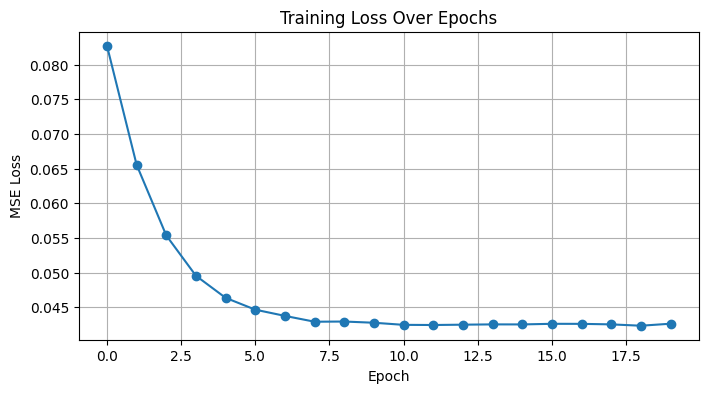

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


## 5. Evaluation and Prediction

Now that the hybrid model has been trained, we evaluate its performance on the test set and visualize the predicted vs actual values. This helps us assess how well the model generalizes to unseen data.


In [10]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.detach().cpu())

# Concatenate batches safely
predictions = torch.cat(predictions).squeeze().numpy()
y_true = y_test_tensor.squeeze().cpu().numpy()



In [11]:
# Check shapes
print("Shape of predictions:", predictions.shape)  # should be (num_samples,)
print("First 5 normalized predictions:", predictions[:5])


Shape of predictions: (499,)
First 5 normalized predictions: [0.2115784  0.21158728 0.21156526 0.21155426 0.2115466 ]


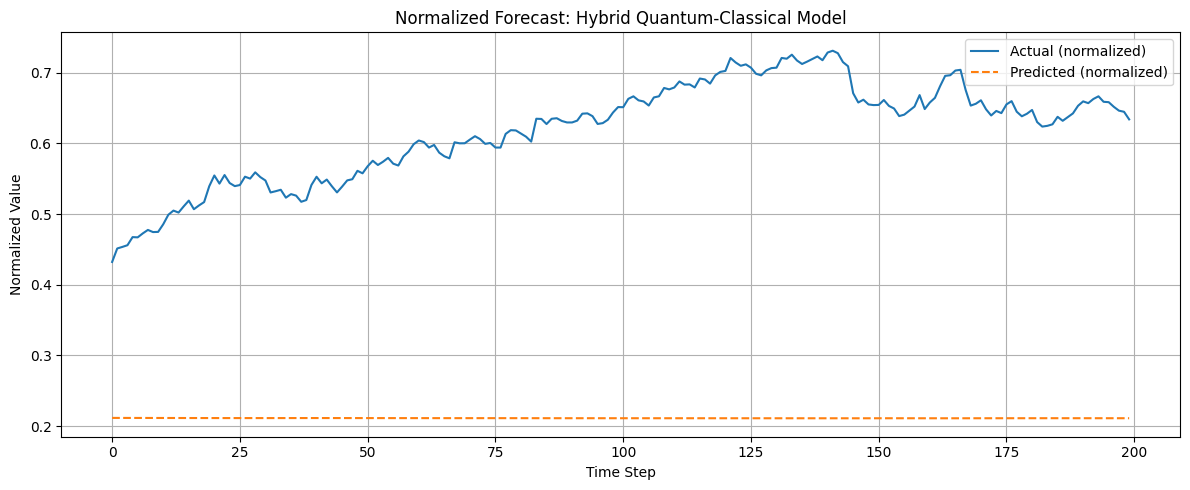

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label="Actual (normalized)")
plt.plot(predictions[:200], label="Predicted (normalized)", linestyle='--')
plt.title("Normalized Forecast: Hybrid Quantum-Classical Model")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
print("Scaler data min:", scaler.data_min_)
print("Scaler data max:", scaler.data_max_)


Scaler data min: [20.67453384]
Scaler data max: [258.73550415]


🔄 Inverse Transform (Denormalize)

In [15]:
# Reshape for inverse_transform (must be 2D)
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_prices = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()



### 5.1 Plot Forecasted vs Actual Prices
We now visualize how well the model’s predictions match the ground truth prices over time.


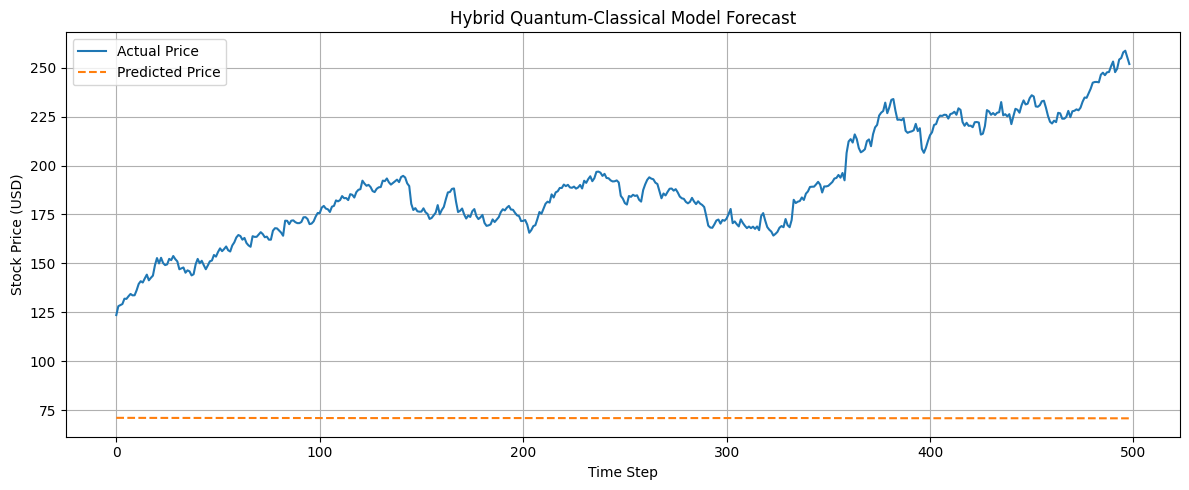

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(true_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price', linestyle='--')
plt.title("Hybrid Quantum-Classical Model Forecast")
plt.xlabel("Time Step")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.2 Evaluation Metrics

We compute standard forecasting error metrics to quantify model performance.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_prices, predicted_prices)
rmse = mean_squared_error(true_prices, predicted_prices, squared=False)

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


MAE  = 118.7042
RMSE = 121.9490


c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
